<a href="https://colab.research.google.com/github/Lahasyakr/cs666student/blob/main/CS666_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

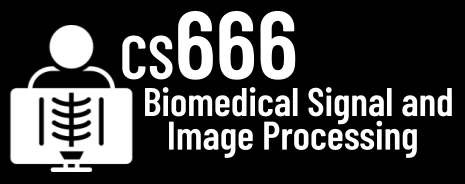
#Assignment 4

In [1]:
# NAME: Lahasya Kakkadde Rajanna

In [2]:
# In this assignment, we will create a Random Forest classifier to detect pneumonia and covid in xrays!

In [3]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
# we are using mahotas again, so lets install it!
!pip install mahotas --no-binary :all:

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Skipping wheel build for mahotas, due to binaries being disabled for it.
  Running setup.py install for mahotas ... done


In [5]:
# our imports include sklearn this time
import mahotas as mh
import os
from sklearn.ensemble import RandomForestClassifier

**Task 1:** Download, extract, and load the data! [15 Points]

In [6]:
# Please download this file: https://cs666.org/data/xray/
# This is a subset of the Kaggle Pneumonia + Covid Datasets!
#
# TODO: Upload xray.zip using the file panel on the left.

In [8]:
# Run this code to extract the zip file and to create
# the folder structure of normal/, pneumonia/, and covid/ images.
# Each folder contains the first images of the Kaggle datasets.
import zipfile
with zipfile.ZipFile('xray.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

NORMAL_DIR = 'normal/'
PNEUMONIA_DIR = 'pneumonia/'
COVID_DIR = 'covid/'

In [9]:
# Here we load the first image from the normal dataset.
img = mh.imread(NORMAL_DIR + 'IM-0115-0001.jpeg')

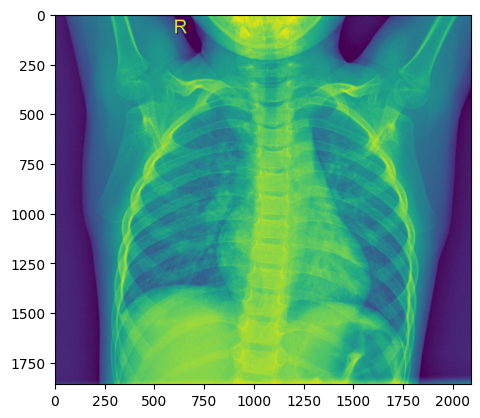

In [10]:
# TODO: Please display this image and print the dimensions!
imshow(img)

In [ ]:
# TODO: YOUR CODE

In [11]:
print("Image dimetions: {} x {}".format(img.shape[0], img.shape[1]))

Image dimetions: 1858 x 2090


**Task 2:** Let's do some data wrangling and more visualization! [35 Points]

In [12]:
folders = [NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR]
data = [[],[],[]]

for f_index,f in enumerate( folders ):
  all_files = os.listdir( f )

  data[f_index] = np.zeros( (len(all_files), 300, 300), dtype=np.float32)

  for i in range(len(all_files)):
    loaded_image = mh.imread( f + '/' + all_files[i] )
    if loaded_image.ndim > 2:
      loaded_image = mh.colors.rgb2gray(loaded_image[:,:,:3])

    loaded_image = mh.imresize( loaded_image, (300, 300) )
    img_shape = loaded_image.shape

    data[f_index][ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [ ]:
# The two code blocks above perform 3 data wrangling operations.
# Which ones?
# Hint: The first two might be more obvious but the third one happens in the
# last line.
# TODO: Operation 1) YOUR ANSWER
# TODO: Operation 2) YOUR ANSWER
# TODO: Operation 3) YOUR ANSWER

 * Operation 1) Looping through the folders which contains (NORMAL_DIR, PNEUMONIA_DIR, COVID_DIR) =, and extracting all files
 * Operation 2) Iterating ove the all files and loading the image and Resizing the image to 300*300 (Resize: mh.imresize( loaded_image, (300, 300) ))
 * Operation 3) Ystoring the resized image in numpy array named "data", which was initialised at the beginning.

In [41]:
# Now, let's look at the first 5 normal_images and the first 5 pneumonia_images.
# TODO: Please visualize multiple images at once.
# Hint: You can use one of the following answers from StackOverflow for this:
# https://stackoverflow.com/questions/41210823/using-plt-imshow-to-display-multiple-images
imshow(data[1][2])

In [33]:
# TODO: YOUR CODE
import matplotlib.pyplot as plt
def show_images(images, n) -> None:
    f = plt.figure(figsize=(15,6))
    for i in range(0,n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)



Normal images


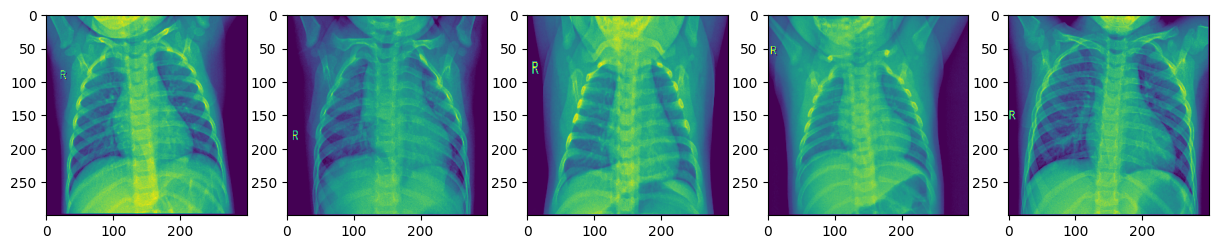

In [34]:
#normal images
print("Normal images")
show_images(data[0], 5) 



pneumonia images


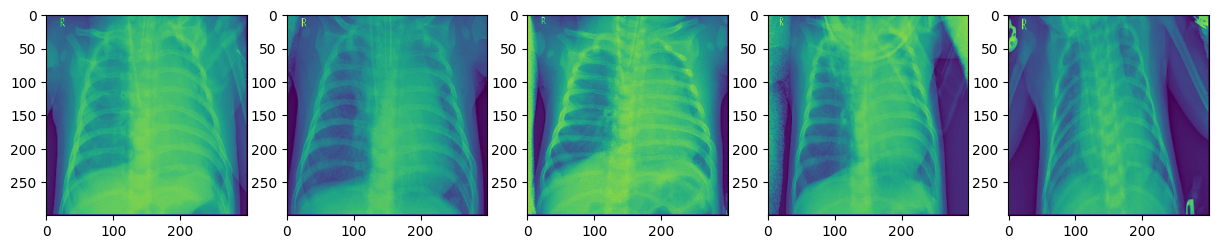

In [35]:
#pneumonia images
print("pneumonia images")
show_images(data[1], 5) 

**Task 3:** Setup training and testing data. [15 Points]

In [ ]:
# Any supervised machine learning algorithm requires disjunct sets of
# training and testing data.
#
# For each, we will create a balanced dataset that includes an equal number
# of normal xrays, pneumonia xrays, and covid xrays.
#
# The training data X_train will include 180 images (60 normal, 60 pneumonia, 60 covid).
# The testing data X_test will include the remaining 120 images (40 normal, 40 pneumonia, 40 covid).
#
# Supervised learning means that we tell the algorithm which image is normal
# and which image is pneumonia. For this, we need the y_train vector.
# The vector shall be 0 for a normal image, and 1 for a pneumonia, and 2 for a covid scan.

In [42]:
TRAINING_COUNT = 60

X_train = np.zeros( (TRAINING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TRAINING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1

In [46]:
# TODO: Please create the y_train vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_train = np.concatenate((np.zeros(TRAINING_COUNT),np.ones(TRAINING_COUNT),np.full(TRAINING_COUNT,2))) 
print(y_train)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


In [47]:
TESTING_COUNT = 40

X_test = np.zeros( (TESTING_COUNT * 3, 300*300 ), dtype=np.float32)
t_pos = 0

for d in data:
  for image in d[0:TESTING_COUNT]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

In [48]:
# TODO: Please create the y_test vector with 0 for a normal image, 
# 1 for a pneumonia, and 2 for covid. This needs to a numpy array.
y_test = np.concatenate((np.zeros(TESTING_COUNT),np.ones(TESTING_COUNT),np.full(TESTING_COUNT,2)))

print(y_test)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]


**Task 4:** Let's train and evaluate the Random Forest! [35 Points]

In [49]:
# Let's shuffle our training data.
p = np.random.permutation(len(X_train))
X_train = X_train[p]
y_train = y_train[p]

In [50]:
# With scikit-learn, we can easily set up a default Random Forest classifier.
clf = RandomForestClassifier()

In [52]:
# Now, we train the classifier with the training data and the training targets.
# We essentially show the classifier an image and tell whether the image is 
# normal or pneumonia or covid.
fitted = clf.fit( X_train, y_train )

In [ ]:
# TODO: In just a few sentences, please explain how the Random Forest works.


In [ ]:
# TODO: YOUR ANSWER



Random forest can be considered as an ensemble of several decision trees. The idea is to aggregate the prediction outcome of multiple decision trees and create a final outcome based on the averaging mechanism (majority voting). It helps the model trained using the random forest to generalize better with the larger population

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses voting approach to remove the predictive accuracy and controls over fitting.

Reference link: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [54]:
# After training, we can see how well the classifier predicts our testing data.
# The following command will return the classification accuracy.
clf.score( X_test, y_test )

1.0

In [ ]:
# TODO: Is the classification accuracy good? And, are you surprised?

In [ ]:
# TODO: YOUR ANSWER

Yes!! The classification accuracy is really good. 

Yes I am surprised, considering the amount of data set that has been used and also 100% accuracy seems unlikely in any setting.

**Bonus:** Let's take a closer look! [33 Points]

In [ ]:
# Let's run the fitted classifier on the remaining covid images.
# You might have noticed that there are 199 covid images but we only used 100 so far.
# Please evaluate the classifier on the remaining (previously unseen) 99 covid images
# and check the performance.

In [70]:
# TODO: YOUR CODE AND YOUR ANSWER
len(data[2])
len(data[2][TESTING_COUNT + TRAINING_COUNT:])
covid_img = data[2][TESTING_COUNT + TRAINING_COUNT:]


X_train_covid = np.zeros( (len(covid_img), 300*300 ), dtype=np.float32)
t_pos = 0

for image in covid_img:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_train[t_pos] = image
    t_pos += 1
y_train_covid = np.zeros(len(covid_img))


TESTING_COUNT_COVID = 40

X_test_covid = np.zeros( (TESTING_COUNT_COVID, 300*300 ), dtype=np.float32)
t_pos = 0

for image in covid_img[0:TESTING_COUNT_COVID]:
    image = image.ravel() # flatten the image
    image /= image.max() # normalize the image
    X_test[t_pos] = image
    t_pos += 1

y_test_covid = np.zeros(TESTING_COUNT_COVID)


p = np.random.permutation(len(X_train_covid))
X_train_covid = X_train_covid[p]
y_train_covid = y_train_covid[p]

clf = RandomForestClassifier()

fitted = clf.fit( X_train_covid, y_train_covid )
accuracy = clf.score( X_test_covid, y_test_covid )

print("classification accuracy for rest of the covide images", accuracy)

classification accuracy for rest of the covide images 1.0


The classification accuracy is really good.

In [ ]:
# Great job!!!
#           ___
#       _.-'   \
#      /        \
#     /          \
#    /            `.___
#   ( .--.)\/(,.--.    `-.
#   ,',-. \   / ,-.`.     )
#  ( /   \     /   \ )   / \
#   || .-|     |-. ||---'|  \
#  _|| | |     | | ||_   |   \
# /. \ |_|.---.|_| / ,\  | .^.\
# `.\ `--"     "--' /,'  |/
#   `>  _________ <'
# ,-' ,---.---.---. `-.
# `--'\    \j/    /`--'
#    `.\         /,'
#      \\_______//
#       `-------'       hjw